In [1]:
import json, ast, re
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

output_img_folder = '../output/cluster-images/'

### Utility Functions

In [2]:
def load_items(filepath):
    print("Loading %s ..." % filepath)
    lines = open(filepath,"r").readlines()
    items = []
    category_map = {}
    for i, line in enumerate(lines):
        line = line.strip()
        if i == 0:
            task_name = line
        elif len(line) > 0:
            parts = line.split(":",1)
            category = parts[0].strip()
            for item in parts[1].strip().split(";"):
                items.append(item)
                category_map[item] = category
    return task_name,items,category_map

In [3]:
def get_dict_data(filepath):
    print("Loading %s ..." % filepath)
    dict_data = json.load(open(filepath))
    dict_data = {ast.literal_eval(k): v for k, v in dict_data.items()}
    #dict_data = {frozenset(k): v for k, v in dict_data.items()}
    return dict_data

In [4]:
def create_similarity_matrix( items, dict_data ):
    n = len(items)
    S = np.zeros([n,n])
    index_map = {}
    for ind, item in enumerate(items):
        index_map[item] = ind
    for pair in dict_data:
        ind1 = index_map[pair[0]]
        ind2 = index_map[pair[1]]
        sim = dict_data[pair]
        S[ind1,ind2] = sim
        S[ind2,ind1] = sim
    return S

### Data Loading

In [5]:
# dataset_id = "european_cities"
# dataset_id = "movie_genres"
# dataset_id = "animal_classes"
# dataset_id = "cuisine"
# dataset_id = "music_genres"
# dataset_id = "nobel_laureates"
dataset_id = "country_continent"

Load the dataset of items

In [6]:
task_name,items,category_map = load_items("../dataset/tasks/%s.txt" % dataset_id )
categories = list(set(category_map.values()))
categories.sort()
print("Task: %s" % task_name)
print("%d categories: %s" % (len(categories),categories) )
print("items: %d" % (len(items)) )

Loading ../dataset/tasks/country_continent.txt ...
Task: Countries by continent
6 categories: ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
items: 104


Create each distance matrix

In [7]:
def create_distance_matrix( items, filepath ):
    sim_dict = get_dict_data( filepath )
    S = create_similarity_matrix( items, sim_dict )
    D = 1-(S/S.max())
    return D

In [8]:
D_wiki = create_distance_matrix(items, "../output/pairwise_similarity/%s_eve.json" % dataset_id )

Loading ../output/pairwise_similarity/country_continent_eve.json ...


In [9]:
D_w2v_cbow = create_distance_matrix(items, "../output/pairwise_similarity/%s_word2vec_cbow.json" % dataset_id )

Loading ../output/pairwise_similarity/country_continent_word2vec_cbow.json ...


In [10]:
D_w2v_sg = create_distance_matrix(items, "../output/pairwise_similarity/%s_word2vec_sg.json" % dataset_id )

Loading ../output/pairwise_similarity/country_continent_word2vec_sg.json ...


In [11]:
D_fast_cbow = create_distance_matrix(items, "../output/pairwise_similarity/%s_fasttext_cbow.json" % dataset_id )

Loading ../output/pairwise_similarity/country_continent_fasttext_cbow.json ...


In [12]:
D_fast_sg = create_distance_matrix(items, "../output/pairwise_similarity/%s_fasttext_sg.json" % dataset_id )

Loading ../output/pairwise_similarity/country_continent_fasttext_sg.json ...


In [13]:
D_glove = create_distance_matrix(items, "../output/pairwise_similarity/%s_glove.json" % dataset_id )

Loading ../output/pairwise_similarity/country_continent_glove.json ...


### Visualization

Use t-SNE to visualize the distances.
See https://github.com/oreillymedia/t-SNE-tutorial

In [14]:
def scatter(items, x, colors, show_text = False):
    palette = np.array(sns.color_palette("hls", max(colors)+1))
    palette_array = np.array([palette[c] for c in colors])
    markers = ["v", (5, 1), (5, 0), (8, 1), "d", "o"]
    marker_array = [markers[c] for c in colors]
    f = plt.figure(figsize=(11, 10))
    ax = plt.subplot(aspect='equal')
#     print(palette[colors])
#     print(marker_array)
#     sc = ax.scatter(x[:,0], x[:,1], lw=0, s=110, c=palette[colors], marker='v')
    sc = list()
#     print(len(x), len(marker_array), len(palette_array))
#     print(x)
    for i in range(len(x)):
        _sc = ax.scatter(x[i][0], x[i][1], lw=0, s=110, c=palette_array[i], marker=marker_array[i])
        sc.append(_sc)

    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    if show_text:
        for i in range(len(items)):
            xtext = x[i][0]
            ytext = x[i][1]
            label = re.sub("\(.*\)","",items[i]).strip()
            if len(label) > 18:
                label = label[0:18].strip() + "..."
            txt = ax.text(xtext, ytext, label, fontsize=7)    
    
    return f, ax, sc

In [15]:
def embed(D):
    model = TSNE(n_components=2, metric="precomputed", random_state=0,learning_rate=100,n_iter=2000)
    return model.fit_transform(D)

In [16]:
def visualize( items, D, show_text = False ):
    colors = []
    for item in items:
        colors.append( categories.index( category_map[item] ) )
    x = embed(D)
    f, ax, sc = scatter(items, x, colors, show_text)

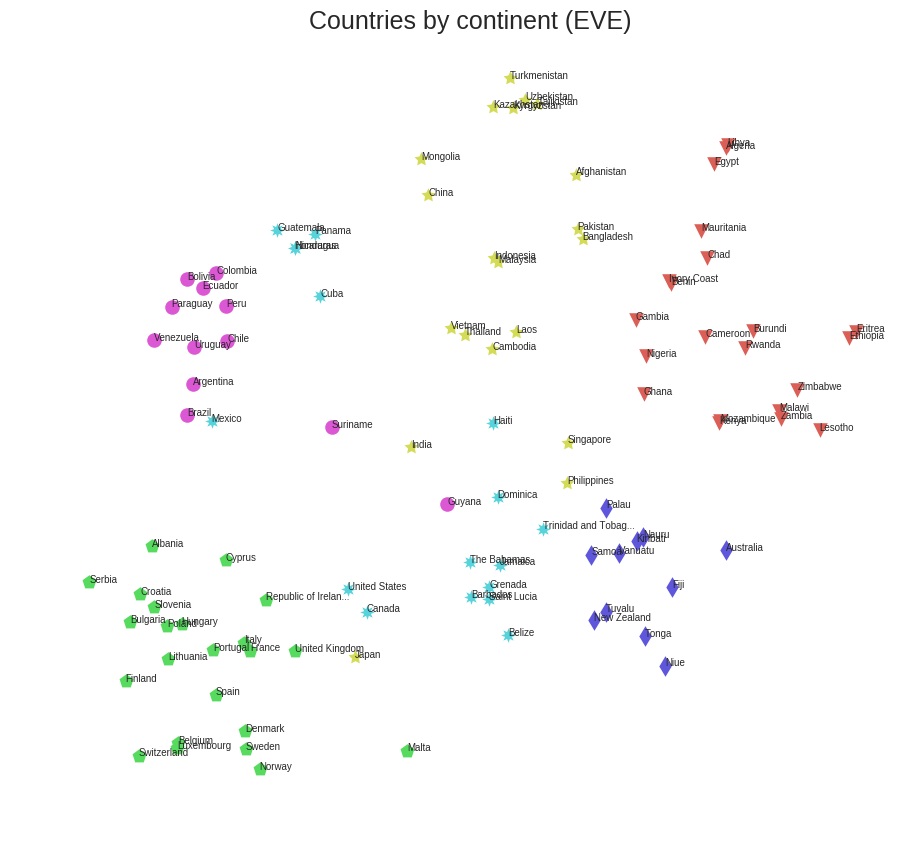

In [17]:
visualize( items, D_wiki, True )
plt.title("%s (EVE)" % task_name )
plt.savefig(output_img_folder + '%s-eve.png' % dataset_id , dpi=100)

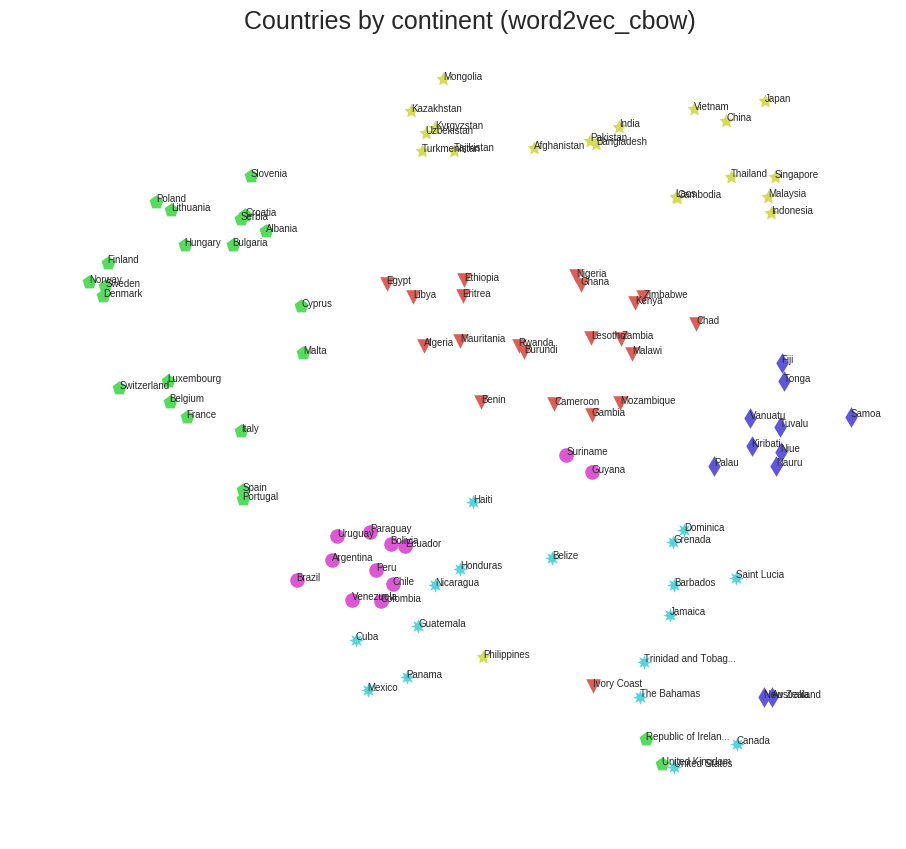

In [18]:
visualize( items, D_w2v_cbow, True )
plt.title("%s (word2vec_cbow)" % task_name )
plt.savefig(output_img_folder + '%s-word2vec_cbow.png' % dataset_id , dpi=100)

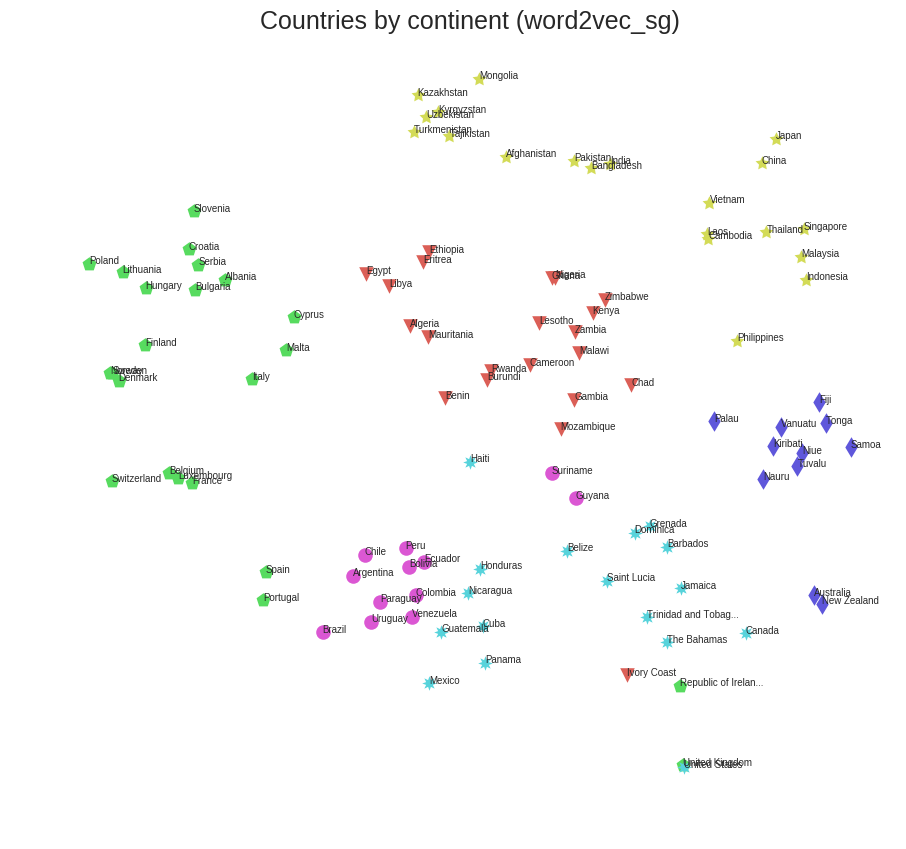

In [19]:
visualize( items, D_w2v_sg, True )
plt.title("%s (word2vec_sg)" % task_name )
plt.savefig(output_img_folder + '%s-word2vec_sg.png' % dataset_id , dpi=100)

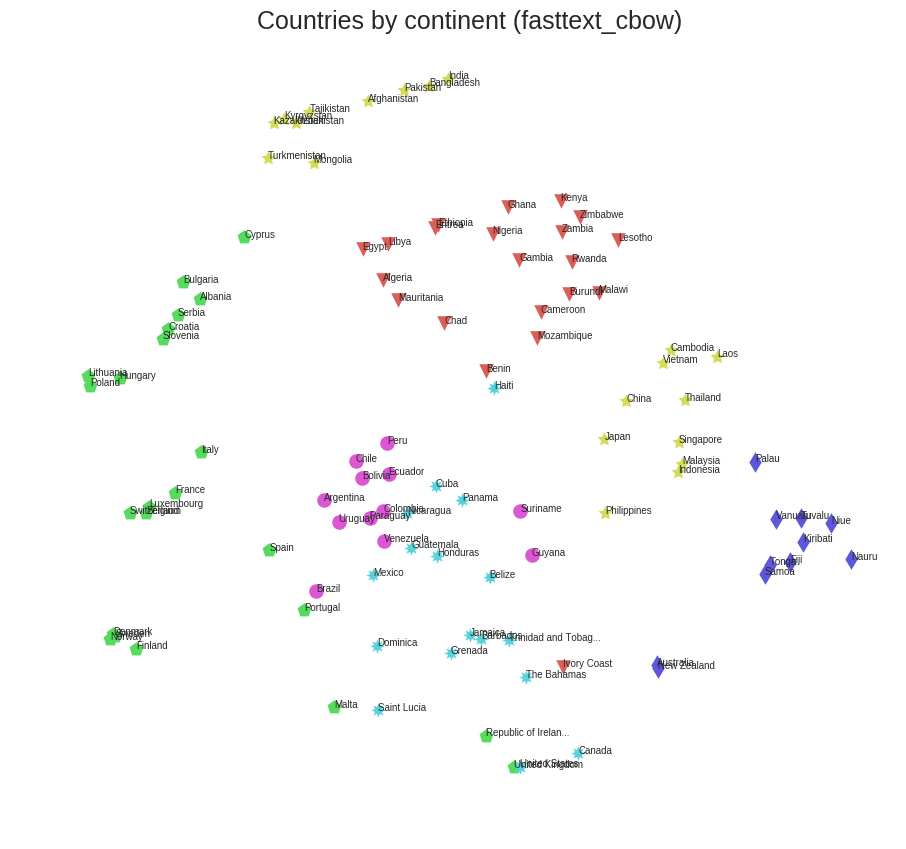

In [20]:
visualize( items, D_fast_cbow, True )
plt.title("%s (fasttext_cbow)" % task_name )
plt.savefig(output_img_folder + '%s-fast_cbow.png' % dataset_id , dpi=100)

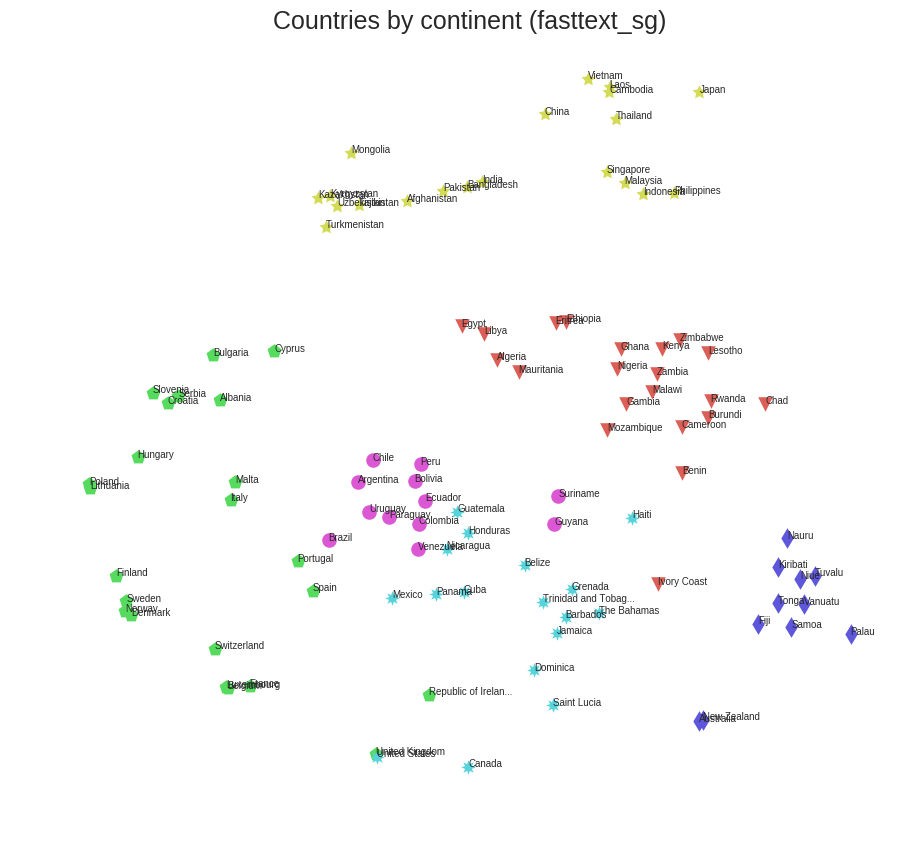

In [21]:
visualize( items, D_fast_sg, True )
plt.title("%s (fasttext_sg)" % task_name )
plt.savefig(output_img_folder + '%s-fast_sg.png' % dataset_id , dpi=100)

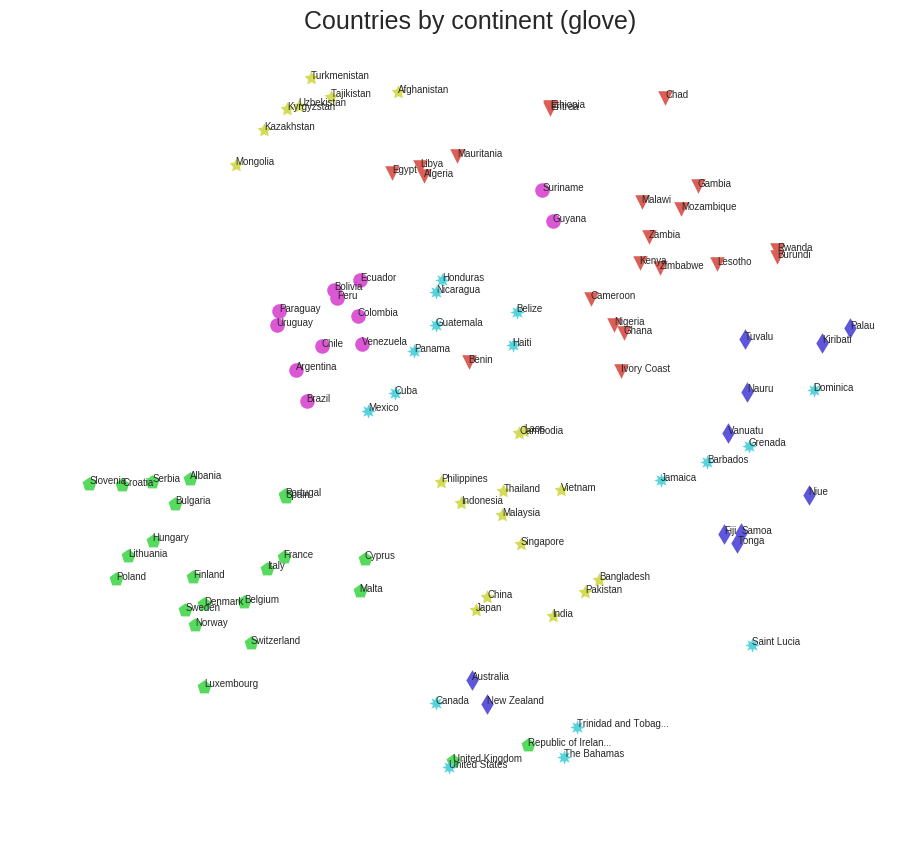

In [22]:
visualize( items, D_glove, True )
plt.title("%s (glove)" % task_name )
plt.savefig(output_img_folder + '%s-glove.png' % dataset_id , dpi=100)